In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import seaborn.objects as so

In [2]:
sns.set_theme(
  context="paper",
  style="whitegrid",
  palette="colorblind",
  font="Source Sans Pro",
)

In [3]:
%config InlineBackend.figure_format = "retina"

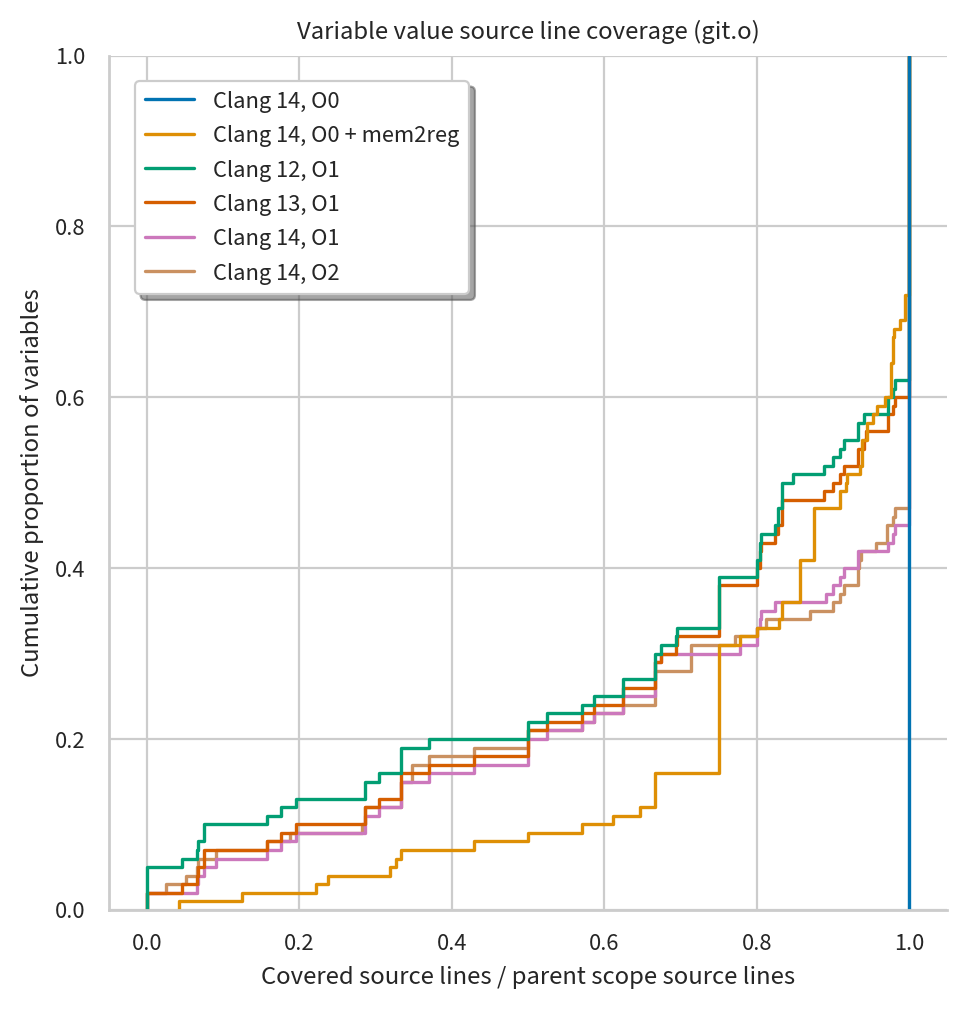

In [4]:
g = sns.displot(
  pd.read_csv("git.o-distribution.csv"),
  x="CL / SL",
  hue="Variant",
  kind="ecdf",
)
sns.move_legend(
  g,
  "upper left",
  bbox_to_anchor=(0.1, 0.95),
  frameon=True,
  shadow=True,
  title=None,
)
g.set(
  title="Variable value source line coverage (git.o)",
  xlabel="Covered source lines / parent scope source lines",
  ylabel="Cumulative proportion of variables",
)

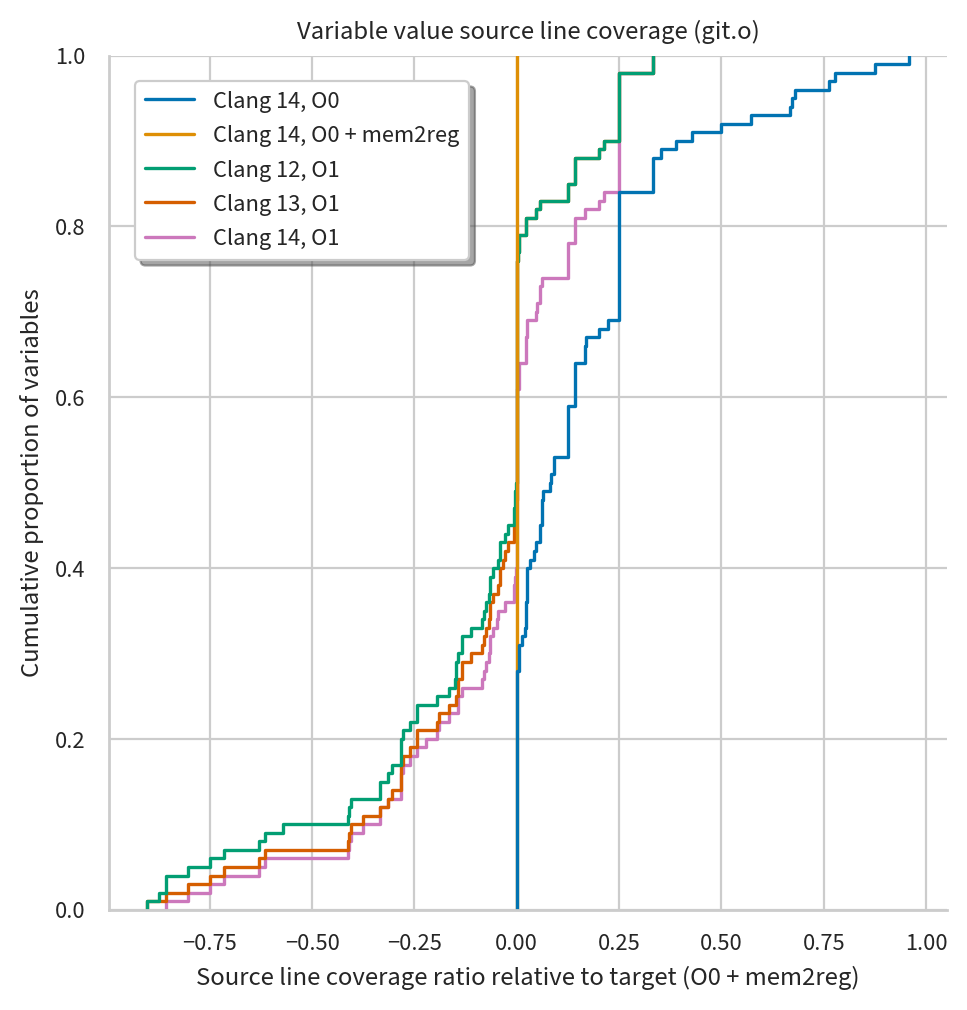

In [5]:
g = sns.displot(
  pd.read_csv("git.o-delta.csv"),
  x="CL / SL Delta",
  hue="Variant",
  kind="ecdf",
)
sns.move_legend(
  g,
  "upper left",
  bbox_to_anchor=(0.1, 0.95),
  frameon=True,
  shadow=True,
  title=None,
)
g.set(
  title="Variable value source line coverage (git.o)",
  xlabel="Source line coverage ratio relative to target (O0 + mem2reg)",
  ylabel="Cumulative proportion of variables",
)

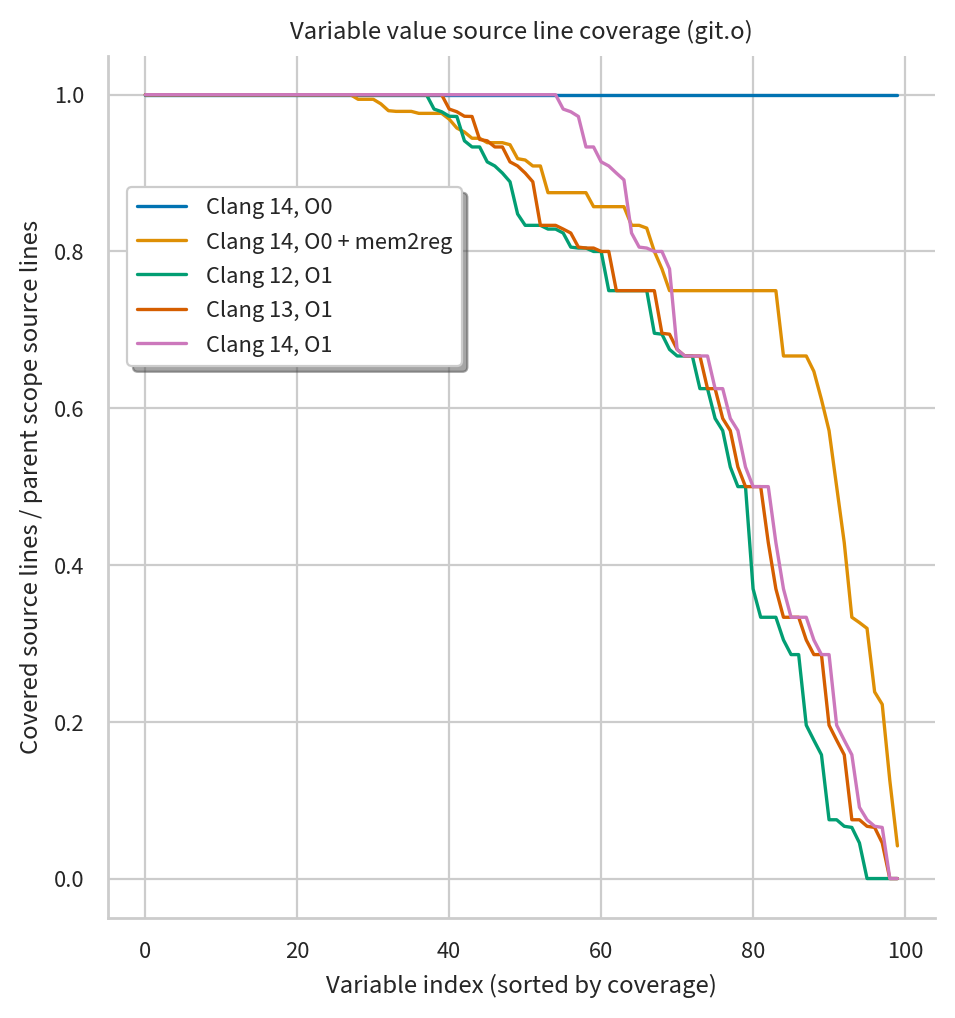

In [6]:
df = pd.read_csv("git.o-distribution.csv")
df["Order"] = df.sort_values(by="CL / SL", ascending=False).groupby("Variant").cumcount()
df = df[df["Variant"].str.contains("O[01]")]
g = sns.relplot(
  df,
  x="Order",
  y="CL / SL",
  hue="Variant",
  kind="line",
)
sns.move_legend(
  g,
  "center left",
  bbox_to_anchor=(0.125, 0.75),
  frameon=True,
  shadow=True,
  title=None,
)
g.set(
  title="Variable value source line coverage (git.o)",
  ylabel="Covered source lines / parent scope source lines",
  xlabel="Variable index (sorted by coverage)",
)

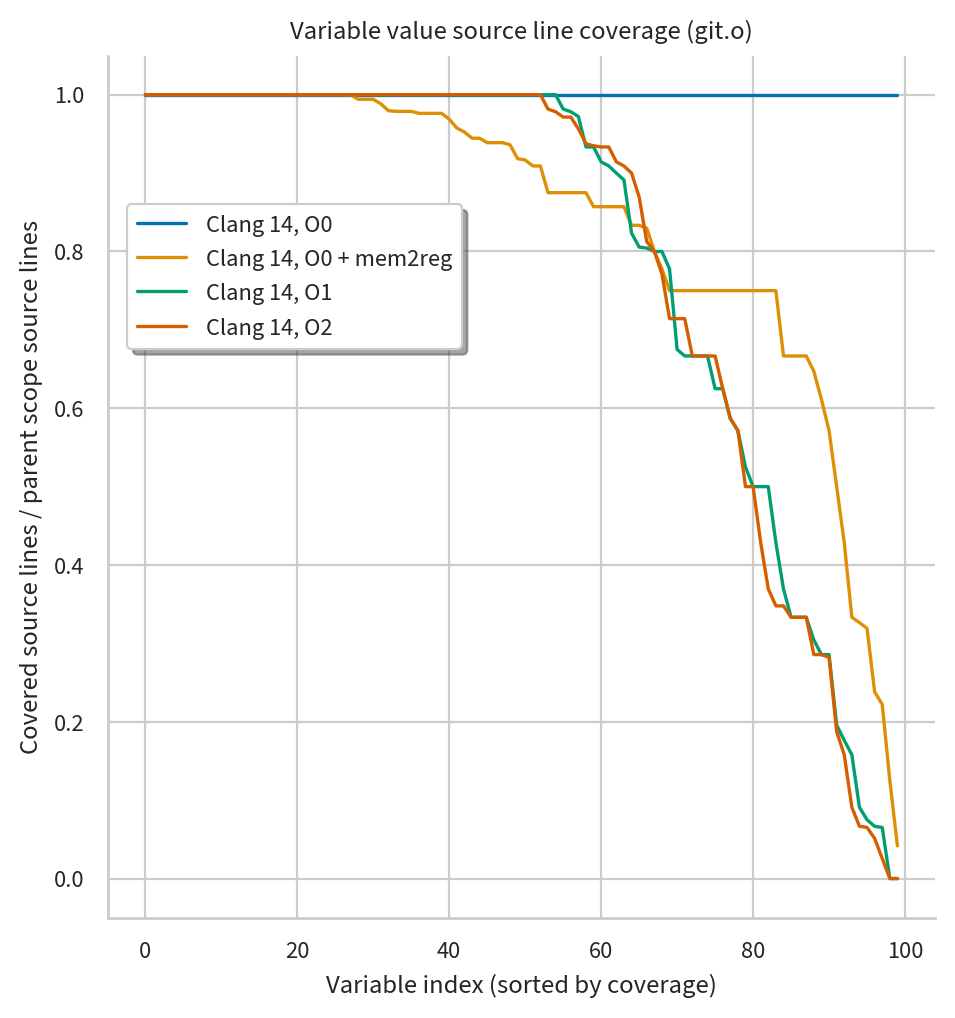

In [10]:
df = pd.read_csv("git.o-distribution.csv")
df["Order"] = df.sort_values(by="CL / SL", ascending=False).groupby("Variant").cumcount()
df = df[df["Variant"].str.contains("Clang 14")]
g = sns.relplot(
  df,
  x="Order",
  y="CL / SL",
  hue="Variant",
  kind="line",
)
sns.move_legend(
  g,
  "center left",
  bbox_to_anchor=(0.125, 0.75),
  frameon=True,
  shadow=True,
  title=None,
)
g.set(
  title="Variable value source line coverage (git.o)",
  ylabel="Covered source lines / parent scope source lines",
  xlabel="Variable index (sorted by coverage)",
)

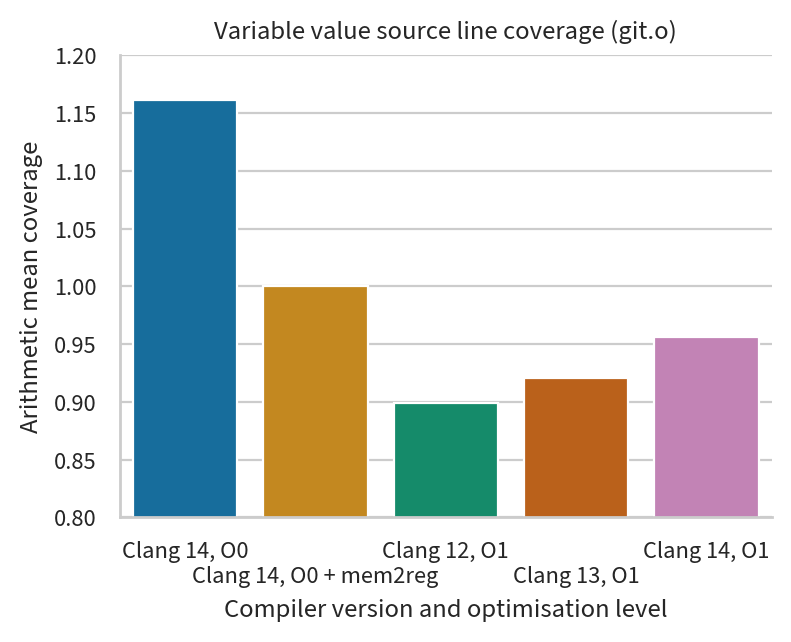

In [9]:
df=pd.read_csv("git.o-average.csv")
g = sns.catplot(
  df,
  x="Variant",
  y="Arithmetic Mean (Normalised)",
  kind="bar",
  height=3.0,
  aspect=4 / 3,
)
g.set(
  title="Variable value source line coverage (git.o)",
  xlabel="Compiler version and optimisation level",
  xticklabels=["\n"*(i%2) + l for i,l in enumerate(df["Variant"])],
  ylabel="Arithmetic mean coverage",
  ybound=(0.8, 1.2),
)